# <center> **Premier League Revenue Simulation** </center>

#### <center>  </center>

### Set Up

In [1]:
# Load necessary libraries
library(gtools)   # for permutations
library(dplyr)
library(ggplot2)
library(gridExtra)
library(kableExtra)
library(IRdisplay)

# Load your data
team_estim <- read.csv("TeamEstim.csv", stringsAsFactors = FALSE)


Warning message:
"package 'gtools' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'gridExtra' was built under R version 4.2.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'kableExtra'


The following object is masked from 'package:dplyr':

    group_rows


Warning message:
"package 'IRdisplay' was built under R version 4.2.3"


## Question 1. Simulate Seasons

### Figure Out Single Season First

In [2]:



# Set up alpha and delta as named vectors
alphaList <- setNames(team_estim$alpha, team_estim$team)
deltaList <- setNames(team_estim$delta, team_estim$team)

# Function to simulate a single match
draw.score <- function(team1, team2) {
  c(
    rpois(1, exp(alphaList[team1] - deltaList[team2])),
    rpois(1, exp(alphaList[team2] - deltaList[team1]))
  )
}

# Generate all matchups (home and away)
allMatches <- permutations(n = length(team_estim$team), r = 2, v = team_estim$team)
colnames(allMatches) <- c("home", "away")

# Simulate each match
ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
for (ii in 1:nrow(allMatches)) {
  ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
  ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
}
colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")

# Convert to data frame for further analysis
ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

# View results
head(ScoresDF)
nrow(ScoresDF)

# No Repeats 
    # 20*38 = 760, but do not recount because teams play eachother
    # 760/2 = 380 total matches (with no repeats)


,home.team,away.team,home.score,away.score
,<chr>,<chr>,<dbl>,<dbl>
1,Arsenal,Aston Villa,1,0
2,Arsenal,Bournemouth,1,1
3,Arsenal,Brentford,2,1
4,Arsenal,Brighton,0,0
5,Arsenal,Chelsea,4,0
6,Arsenal,Crystal Palace,0,0


[1] 380

In [3]:
# Create New Column to identify weather the home or away team wins (or draws) by comparing the .score variables

ScoresDF <- ScoresDF %>%
  mutate(winner = case_when(
    home.score > away.score ~ "Home",
    home.score < away.score ~ "Away",
    home.score == away.score ~ "Draw"
  ))

In [4]:
head(ScoresDF)

,home.team,away.team,home.score,away.score,winner
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Arsenal,Aston Villa,1,0,Home
2,Arsenal,Bournemouth,1,1,Draw
3,Arsenal,Brentford,2,1,Home
4,Arsenal,Brighton,0,0,Draw
5,Arsenal,Chelsea,4,0,Home
6,Arsenal,Crystal Palace,0,0,Draw


In [5]:
# Create a new column that prints the name of the winner
# We still have to figure out draws so we leave them alone for now

ScoresDF <- ScoresDF %>%
  mutate(winning_team = case_when(
    winner == "Home" ~ home.team,
    winner == "Away" ~ away.team,
    winner == "Draw" ~ "Draw"
  ))
head(ScoresDF)

,home.team,away.team,home.score,away.score,winner,winning_team
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Arsenal,Aston Villa,1,0,Home,Arsenal
2,Arsenal,Bournemouth,1,1,Draw,Draw
3,Arsenal,Brentford,2,1,Home,Arsenal
4,Arsenal,Brighton,0,0,Draw,Draw
5,Arsenal,Chelsea,4,0,Home,Arsenal
6,Arsenal,Crystal Palace,0,0,Draw,Draw


In [6]:
# Step 2: Count wins per team (exclude draws)
points_wins <- ScoresDF %>%
  filter(winning_team != "Draw") %>%
  count(winning_team, name = "wins") %>%
  mutate(win_points = wins * 3)

# Step 3: Count draws (both home and away teams)
draw_points_home <- ScoresDF %>%
  filter(winner == "Draw") %>%
  count(home.team, name = "draws_home")

draw_points_away <- ScoresDF %>%
  filter(winner == "Draw") %>%
  count(away.team, name = "draws_away")

points_wins
draw_points_home
draw_points_away

winning_team,wins,win_points
<chr>,<int>,<dbl>
Arsenal,25,75
Aston Villa,19,57
Bournemouth,13,39
Brentford,14,42
Brighton,21,63
Chelsea,17,51
Crystal Palace,13,39
Everton,5,15
Fulham,13,39


home.team,draws_home
<chr>,<int>
Arsenal,6
Aston Villa,5
Bournemouth,4
Brentford,5
Brighton,4
Chelsea,2
Crystal Palace,3
Everton,11
Fulham,4


away.team,draws_away
<chr>,<int>
Arsenal,2
Aston Villa,5
Bournemouth,7
Brentford,3
Brighton,3
Chelsea,8
Crystal Palace,5
Everton,9
Fulham,7


In [7]:
# Rename before joining to avoid column conflict
home_draws <- draw_points_home %>%
  rename(team = home.team)

away_draws <- draw_points_away %>%
  rename(team = away.team)

# Merge draws and sum them up
draw_points <- full_join(home_draws, away_draws, by = "team") %>%
  mutate(
    draws_home = coalesce(draws_home, 0),
    draws_away = coalesce(draws_away, 0),
    total_draws = draws_home + draws_away,
    draw_points = total_draws * 1
  ) %>%
  select(team, total_draws, draw_points)

# Prepare win table (already has winning_team)
points_wins <- points_wins %>%
  rename(team = winning_team)

# Combine win and draw points
points_table <- full_join(points_wins, draw_points, by = "team") %>%
  mutate(
    wins = coalesce(wins, 0),
    win_points = coalesce(win_points, 0),
    total_draws = coalesce(total_draws, 0),
    draw_points = coalesce(draw_points, 0),
    total_points = win_points + draw_points
  ) %>%
  select(team, wins, total_draws, total_points) %>%
  arrange(desc(total_points))

# View the final points table
print(points_table)



             team wins total_draws total_points
1         Arsenal   25           8           83
2        Man City   25           6           81
3       Liverpool   25           4           79
4        Brighton   21           7           70
5     Aston Villa   19          10           67
6       Tottenham   19          10           67
7         Chelsea   17          10           61
8       Newcastle   16           6           54
9      Man United   14          11           53
10  Nott'm Forest   13          13           52
11    Bournemouth   13          11           50
12      Brentford   14           8           50
13         Fulham   13          11           50
14 Crystal Palace   13           8           47
15         Wolves    9          12           39
16        Everton    5          20           35
17       West Ham    8          10           34
18        Ipswich    6          13           31
19    Southampton    3          12           21
20      Leicester    1          12      

In [8]:
# Convert to data frame
pt_df<- as.data.frame(points_table)

pt_df

team,wins,total_draws,total_points
<chr>,<dbl>,<dbl>,<dbl>
Arsenal,25,8,83
Man City,25,6,81
Liverpool,25,4,79
Brighton,21,7,70
Aston Villa,19,10,67
Tottenham,19,10,67
Chelsea,17,10,61
Newcastle,16,6,54
Man United,14,11,53


### Simulate Many Seasons

In [9]:

# Create a function that joins all of our season simulation work above

simulate_season <- function(alphaList, deltaList, team_names) {
  # Draw a single match score
  draw.score <- function(team1, team2) {
    c(
      rpois(1, exp(alphaList[team1] - deltaList[team2])),
      rpois(1, exp(alphaList[team2] - deltaList[team1]))
    )
  }

  # All matches
  allMatches <- permutations(length(team_names), 2, v = team_names)
  colnames(allMatches) <- c("home", "away")

  # Simulate season
  ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
  for (ii in 1:nrow(allMatches)) {
    ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
    ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
  }
  colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")
  ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
  ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
  ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

  # Add result column
  ScoresDF$winner <- ifelse(
    ScoresDF$home.score > ScoresDF$away.score, "Home",
    ifelse(ScoresDF$home.score < ScoresDF$away.score, "Away", "Draw")
  )
  ScoresDF$winning_team <- ifelse(
    ScoresDF$winner == "Home", ScoresDF$home.team,
    ifelse(ScoresDF$winner == "Away", ScoresDF$away.team, "Draw")
  )

  # Count wins
  win_points <- ScoresDF %>%
    filter(winning_team != "Draw") %>%
    count(winning_team, name = "wins") %>%
    mutate(points = wins * 3)

  # Count draws
  draw_points_home <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(home.team, name = "draws_home") %>%
    rename(team = home.team)

  draw_points_away <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(away.team, name = "draws_away") %>%
    rename(team = away.team)

  draw_points <- full_join(draw_points_home, draw_points_away, by = "team") %>%
    mutate(
      draws_home = coalesce(draws_home, 0),
      draws_away = coalesce(draws_away, 0),
      total_draws = draws_home + draws_away,
      points = total_draws
    )

  # Combine win and draw points
  points_table <- full_join(
    win_points %>% rename(team = winning_team),
    draw_points, by = "team"
  ) %>%
    mutate(
      points.x = coalesce(points.x, 0),
      points.y = coalesce(points.y, 0),
      total_points = points.x + points.y
    ) %>%
    select(team, total_points)

  # Return total points per team for this season
  out <- setNames(points_table$total_points, points_table$team)
  return(out)
}


In [10]:
monte.carlo.sim<-function(fun,fun.arg,nSims=10000){
    # this line just runs fun(arguments in fun.arg list) so if fun.arg=(x,y,z) do.call(fun,fun.arg) runs fun(x,y,z)
    rep1<- do.call(fun,fun.arg) 
    # Set the dimensions for the output matrix
    nc<-length(rep1)
    lbl<-names(rep1)
    outputMatrix <- matrix(1,nrow=nSims, ncol=nc)
    outputMatrix[1, ]<-rep1 # write the sim to the first line
    for (rep in 2:nSims) { # for each of the remaining sims, add them in
        outputMatrix[rep, ] <- do.call(fun,fun.arg)
    }
    df<-data.frame(outputMatrix) # convert it to a data frame
    names(df)<-lbl  # get the names from the simulation output lbl
    return(df) # return the data frame as the output
}

In [11]:
# Prepare input data
alphaList <- setNames(team_estim$alpha, team_estim$team)
deltaList <- setNames(team_estim$delta, team_estim$team)
team_names <- team_estim$team

In [12]:
# Simulate 1000 seasons
season_sims <- monte.carlo.sim(
  fun = simulate_season,
  fun.arg = list(alphaList = alphaList, deltaList = deltaList, team_names = team_names),
  nSims = 1000
)

# Example: average points per team
colMeans(season_sims)

Arsenal    Aston Villa    Bournemouth      Brentford       Brighton 
        76.267         54.178         51.742         50.078         52.675 
       Chelsea Crystal Palace        Everton         Fulham        Ipswich 
        60.408         51.857         45.979         51.814         30.866 
     Leicester      Liverpool       Man City     Man United      Newcastle 
        27.486         77.214         73.979         50.119         59.808 
 Nott'm Forest    Southampton      Tottenham       West Ham         Wolves 
        51.332         22.948         58.934         43.991         44.049

In [13]:
# Create Df

# Calculate average points across all simulations
avg_points <- colMeans(season_sims)

# Convert to data frame
avg_points_df <- data.frame(
  team = names(avg_points),
  average_points = as.numeric(avg_points)
)

# Sort by highest average points
avg_points_df <- avg_points_df %>%
  arrange(desc(average_points))

# View result
head(avg_points_df)

,team,average_points
,<chr>,<dbl>
1,Liverpool,77.214
2,Arsenal,76.267
3,Man City,73.979
4,Chelsea,60.408
5,Newcastle,59.808
6,Tottenham,58.934


### Adding Revenue

In [14]:
# Hard code value of earnings and position

revenue_by_position <- data.frame(
  position = 1:20,
  revenue_million_gbp = c(
    149.6, 145.9, 142.1, 138.4, 73.7, 70.0, 55.2, 33.5, 29.8, 26.0,
    22.3, 18.6, 14.9, 11.2, 7.5, 3.7, 0, -88.7, -92.5, -96.2
  )
)

In [15]:
# Create an empty matrix to store revenue per team per season
revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(revenue_matrix) <- colnames(season_sims)
rownames(revenue_matrix) <- 1:nrow(season_sims)

# Loop through each simulated season
for (i in 1:nrow(season_sims)) {
  season_points <- as.numeric(season_sims[i, ])
  names(season_points) <- colnames(season_sims)

  ranked_teams <- names(sort(season_points, decreasing = TRUE))

  # Assign revenue based on league position
  for (j in 1:20) {
    team <- ranked_teams[j]
    revenue_matrix[i, team] <- revenue_by_position$revenue_million_gbp[j]
  }
}


In [16]:
revenue_df <- as.data.frame(revenue_matrix)
head(revenue_df)

,Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich,Leicester,Liverpool,Man City,Man United,Newcastle,Nott'm Forest,Southampton,Tottenham,West Ham,Wolves
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,142.1,33.5,3.7,70.0,29.8,73.7,22.3,14.9,18.6,-88.7,-92.5,149.6,138.4,0.0,7.5,55.2,-96.2,145.9,11.2,26.0
2,149.6,18.6,29.8,0.0,73.7,138.4,55.2,26.0,70.0,-88.7,-92.5,145.9,142.1,7.5,33.5,22.3,-96.2,11.2,14.9,3.7
3,149.6,22.3,55.2,7.5,14.9,145.9,33.5,11.2,26.0,-92.5,3.7,73.7,142.1,18.6,70.0,29.8,-96.2,138.4,-88.7,0.0
4,142.1,22.3,18.6,70.0,11.2,55.2,14.9,7.5,26.0,-88.7,-92.5,149.6,138.4,33.5,145.9,29.8,-96.2,73.7,0.0,3.7
5,149.6,22.3,18.6,55.2,3.7,73.7,29.8,33.5,11.2,-88.7,-92.5,138.4,145.9,14.9,142.1,70.0,-96.2,26.0,7.5,0.0
6,145.9,29.8,-88.7,11.2,138.4,73.7,18.6,3.7,55.2,0.0,-96.2,142.1,149.6,33.5,26.0,22.3,-92.5,70.0,14.9,7.5


In [17]:
# average the revenue of each team for all 1000 seasons
avg_revenue <- colMeans(revenue_df)

avg_revenue_df <- data.frame(
  team = names(avg_revenue),
  average_revenue_million = as.numeric(avg_revenue)
)

# Create the table
html_table<- avg_revenue_df %>%
  arrange(desc(average_revenue_million)) %>%
  mutate(
    average_revenue_million = round(average_revenue_million, 1)
  ) %>%
  kable("html", caption = "Average Revenue per Team (Simulated Seasons)",
        col.names = c("Team", "Average Revenue (GBP Millions)")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed", "responsive"),
                full_width = FALSE, position = "left")

# Display in Jupyter Notebook
display_html(as.character(html_table))


Team,Average Revenue (GBP Millions)
Liverpool,142.7
Arsenal,142.1
Man City,135.7
Chelsea,76.1
Newcastle,68.6
Tottenham,64.4
Aston Villa,44.6
Brighton,36.7
Bournemouth,32.7
Crystal Palace,32.6


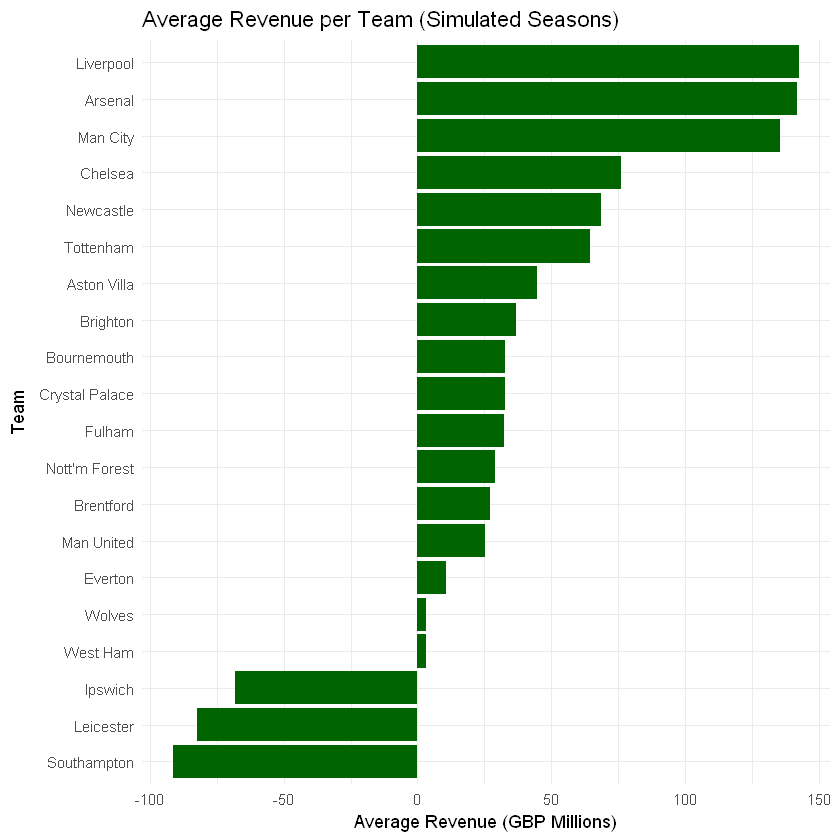

In [18]:
# Order teams by average revenue for clean plotting
avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team[order(avg_revenue_df$average_revenue_million)])

# Plot
ggplot(avg_revenue_df, aes(x = team, y = average_revenue_million)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Average Revenue per Team (Simulated Seasons)",
    x = "Team",
    y = "Average Revenue (GBP Millions)"
  ) +
  theme_minimal()

## Question 2

In [19]:
# Calculate average and standard deviation of revenue in sims
avg_revenue <- colMeans(revenue_df)
revenue_sd <- apply(revenue_df, 2, sd)

# Combine into one data frame
avg_revenue_df <- data.frame(
  team = names(avg_revenue),
  average_revenue_million = as.numeric(avg_revenue),
  sd_revenue = as.numeric(revenue_sd)
)

#  Arrange by highest SD and display top 8
top8_revenue_sd <- avg_revenue_df %>%
  arrange(desc(sd_revenue)) %>%
  head(8)

# Create and style the table
top8_table <- top8_revenue_sd %>%
  mutate(
    average_revenue_million = round(average_revenue_million, 1),
    sd_revenue = round(sd_revenue, 1)
  ) %>%
  kable("html", caption = "Most Variable Teams by Simulated Revenue (Top 8)",
        col.names = c("Team", "Avg Revenue (GBP M)", "Revenue SD (GBP M)")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"),
                full_width = FALSE, position = "left")

# Render in Jupyter Notebook
display_html(as.character(top8_table))

Team,Avg Revenue (GBP M),Revenue SD (GBP M)
Chelsea,76.1,47.7
Tottenham,64.4,45.8
Newcastle,68.6,44.7
Aston Villa,44.6,40.6
Ipswich,-68.3,40.4
Man United,25.1,36.0
Bournemouth,32.7,35.4
West Ham,3.1,35.0


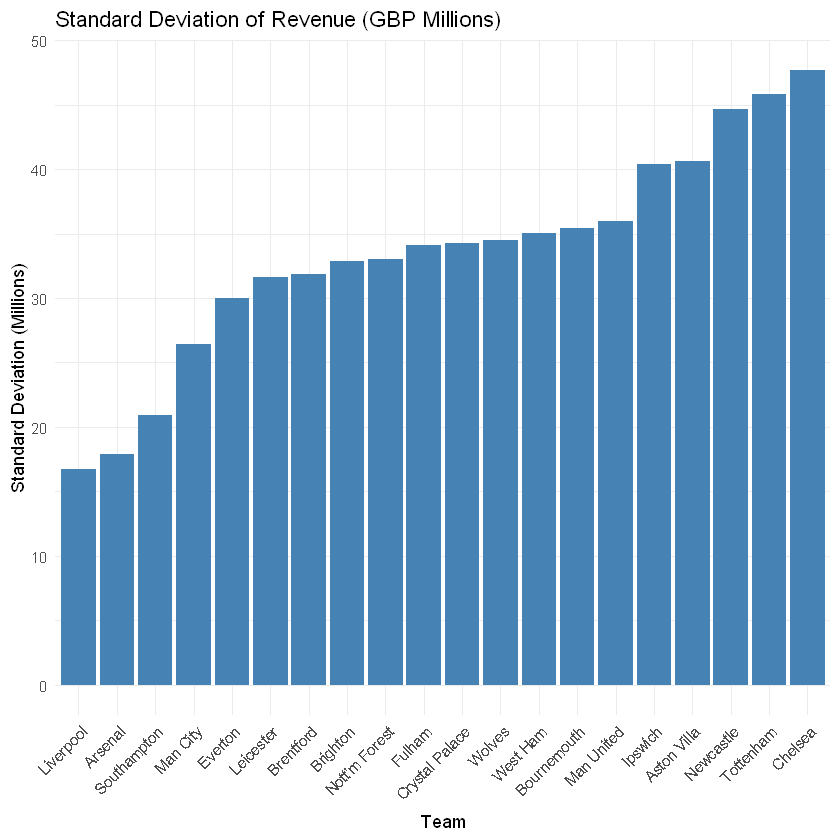

In [20]:
options(repr.plot.width = NULL, repr.plot.height = NULL)

# Step 1: Order the teams by sd_revenue
avg_revenue_df <- avg_revenue_df %>%
  arrange(sd_revenue)

# Step 2: Convert team column to a factor with levels in the desired order
avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team)



ggplot(avg_revenue_df, aes(x = team, y = sd_revenue)) +
  geom_bar(stat = "identity", fill = "steelblue") +
 
  labs(
    title = "Standard Deviation of Revenue (GBP Millions)",
    x = "Team",
    y = "Standard Deviation (Millions)"
  ) +
  theme_minimal()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



In [21]:
# Create Confidence Intervals

nSims <- 1000

avg_revenue_df <- avg_revenue_df %>%
  mutate(
    ci_lower = average_revenue_million - 1.96 * sd_revenue / sqrt(nSims),
    ci_upper = average_revenue_million + 1.96 * sd_revenue / sqrt(nSims)
  )


avg_revenue_df <- avg_revenue_df %>%
  arrange(desc(-average_revenue_million))

avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team)

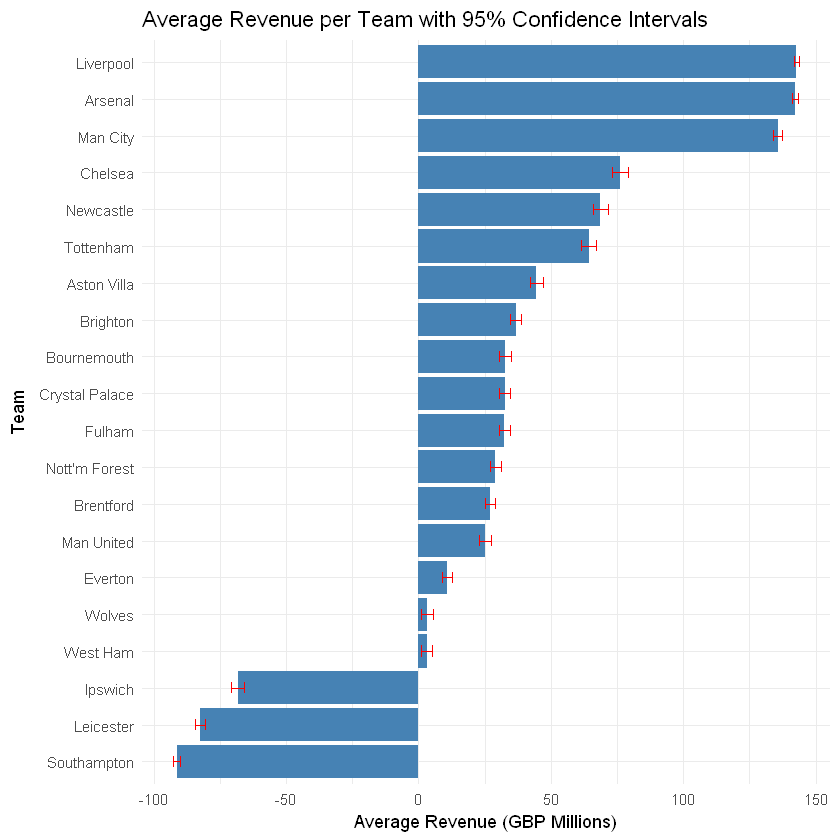

In [22]:
options(repr.plot.width = NULL, repr.plot.height = NULL)

# Plot average revenues with confidence intervals
ggplot(avg_revenue_df, aes(x = team, y = average_revenue_million)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_errorbar(
    aes(ymin = ci_lower, ymax = ci_upper),
    width = 0.3,
    color = "red"
  ) +
  coord_flip() +
  labs(
    title = "Average Revenue per Team with 95% Confidence Intervals",
    x = "Team",
    y = "Average Revenue (GBP Millions)"
  ) +
  theme_minimal()

## Question 3

**Findings**

Teams that are more variable (from question 2) tend to benefit more from a lucky win. This is intuitive because they often sit on the edge of important cutoffs and 3-point bump can easily push them up or down several ranks, which means a big revenue swing. Leading to high variation, and marginal effect of a win

**Method**

+ In each simulated season (already simulated):

    + For every team, we simulate a lucky win by simply adding 3 points to their total — the amount they'd receive for winning a match.

    + All other teams' points remain unchanged.

    + We re-rank the league based on the new point totals and recalculate revenue.

    + We record the difference in revenue for that team before and after the bonus.
    
+ For all the teams we take average the marginal revenue difference to view marginal effect of randomly winning one more game.

+ 1,000 seasons × 20 teams = 20,000 simulations.

In [23]:
# Create matrix to hold marginal revenue gains
marginal_gain_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(marginal_gain_matrix) <- colnames(season_sims)

# Loop over each simulation
for (i in 1:nrow(season_sims)) {
  original_points <- as.numeric(season_sims[i, ])
  names(original_points) <- colnames(season_sims)
  
  original_ranking <- names(sort(original_points, decreasing = TRUE))
  original_revenue <- setNames(revenue_by_position$revenue_million_gbp, original_ranking)
  
  for (team in names(original_points)) {
    # Add 3 points (a "lucky win")
    new_points <- original_points
    new_points[team] <- new_points[team] + 3
    
    new_ranking <- names(sort(new_points, decreasing = TRUE))
    new_revenue <- setNames(revenue_by_position$revenue_million_gbp, new_ranking)
    
    # Revenue difference for this team only
    marginal_gain_matrix[i, team] <- new_revenue[team] - original_revenue[team]
  }
}


In [24]:
marginal_gain_avg <- colMeans(marginal_gain_matrix)

marginal_gain_df <- data.frame(
  team = names(marginal_gain_avg),
  marginal_revenue_gain = marginal_gain_avg
) %>%
  arrange(desc(marginal_revenue_gain))

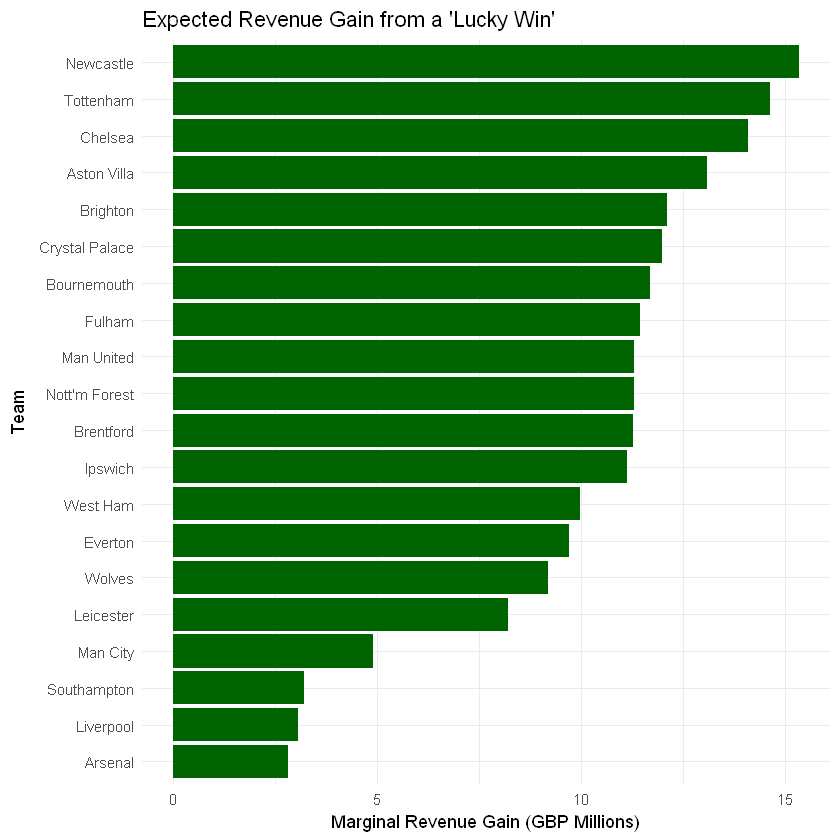

In [25]:
# Reorder the 'team' factor by marginal_revenue_gain
marginal_gain_df$team <- factor(marginal_gain_df$team, levels = marginal_gain_df$team[order(marginal_gain_df$marginal_revenue_gain)])


ggplot(marginal_gain_df, aes(x = team, y = marginal_revenue_gain)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Expected Revenue Gain from a 'Lucky Win'",
    x = "Team",
    y = "Marginal Revenue Gain (GBP Millions)"
  ) +
  theme_minimal()


### Slightly Harder Way (Taking into Account the Loss as well)

**Method**

Simulates 1,000 full seasons (again). (redefines function to output in list format).

+ For each season:

    + Stores team points and match results.

+ For each team in each season:

    + Randomly selects one match they lost.

+ Flips that to a win (adds 3 points to them, removes 3 from the opponent).

+ Re-ranks all teams.

+ Re-assigns revenue based on new ranks.

+ Stores the difference in revenue from the original.

+ Averages this revenue difference across 1,000 simulations → gives the expected benefit of a lucky win for each team.

+ 20 teams × 1,000 simulations = 20,000 “flip scenarios”

In [26]:

# Create a function that exports simulation in list format (compatability)
    # copy and paste base code and change output line and add _l to note as different function
    # Monte carlo sim function doesnt work bc not compatible with matrix can’t hold list elements

simulate_season_l <- function(alphaList, deltaList, team_names) {
  # Draw a single match score
  draw.score <- function(team1, team2) {
    c(
      rpois(1, exp(alphaList[team1] - deltaList[team2])),
      rpois(1, exp(alphaList[team2] - deltaList[team1]))
    )
  }

  # All matches
  allMatches <- permutations(length(team_names), 2, v = team_names)
  colnames(allMatches) <- c("home", "away")

  # Simulate season
  ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
  for (ii in 1:nrow(allMatches)) {
    ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
    ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
  }
  colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")
  ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
  ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
  ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

  # Add result column
  ScoresDF$winner <- ifelse(
    ScoresDF$home.score > ScoresDF$away.score, "Home",
    ifelse(ScoresDF$home.score < ScoresDF$away.score, "Away", "Draw")
  )
  ScoresDF$winning_team <- ifelse(
    ScoresDF$winner == "Home", ScoresDF$home.team,
    ifelse(ScoresDF$winner == "Away", ScoresDF$away.team, "Draw")
  )

  # Count wins
  win_points <- ScoresDF %>%
    filter(winning_team != "Draw") %>%
    count(winning_team, name = "wins") %>%
    mutate(points = wins * 3)

  # Count draws
  draw_points_home <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(home.team, name = "draws_home") %>%
    rename(team = home.team)

  draw_points_away <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(away.team, name = "draws_away") %>%
    rename(team = away.team)

  draw_points <- full_join(draw_points_home, draw_points_away, by = "team") %>%
    mutate(
      draws_home = coalesce(draws_home, 0),
      draws_away = coalesce(draws_away, 0),
      total_draws = draws_home + draws_away,
      points = total_draws
    )

  # Combine win and draw points
  points_table <- full_join(
    win_points %>% rename(team = winning_team),
    draw_points, by = "team"
  ) %>%
    mutate(
      points.x = coalesce(points.x, 0),
      points.y = coalesce(points.y, 0),
      total_points = points.x + points.y
    ) %>%
    select(team, total_points)

  # Return total points per team for this season
  out <- setNames(points_table$total_points, points_table$team)
  # ✅ Return both match data and point totals
  return(list(points = out, matches = ScoresDF))
}


In [27]:
num_sims <- 1000

# Run simulations and store full results (list of lists)
season_results <- lapply(1:num_sims, function(i) simulate_season_l(alphaList, deltaList, team_names))


In [28]:
set.seed(8)

# Extract season points matrix
season_sims <- t(sapply(season_results, function(x) x$points))
match_results_list <- lapply(season_results, function(x) x$matches)
# Matrix to store revenue gains per team across simulations
marginal_gain_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(marginal_gain_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  original_points <- as.numeric(season_sims[i, ])
  names(original_points) <- colnames(season_sims)
  
  original_ranking <- names(sort(original_points, decreasing = TRUE))
  original_revenue <- setNames(revenue_by_position$revenue_million_gbp, original_ranking)
  
  # Use the match results for this simulated season
  sim_scores <- match_results_list[[i]]  # Assuming you stored per-season match results

  for (team in names(original_points)) {
    # Identify all matches the team lost
    losses <- sim_scores %>%
      filter((home.team == team & home.score < away.score) |
             (away.team == team & away.score < home.score))

    # Skip if no losses to flip
    if (nrow(losses) == 0) next

    # Randomly pick one loss to flip
    flip_index <- sample(1:nrow(losses), 1)
    match <- losses[flip_index, ]

    # Create new points vector with the loss flipped to a win
    new_points <- original_points

    # Adjust points: losing team gains 3, winning team loses 3 (adjust for draws if needed)
    if (match$home.team == team) {
      opponent <- match$away.team
      if (match$home.score < match$away.score) {
        new_points[team] <- new_points[team] + 3
        new_points[opponent] <- new_points[opponent] - 3
      }
    } else {
      opponent <- match$home.team
      if (match$away.score < match$home.score) {
        new_points[team] <- new_points[team] + 3
        new_points[opponent] <- new_points[opponent] - 3
      }
    }

    # Re-rank and reassign revenue
    new_ranking <- names(sort(new_points, decreasing = TRUE))
    new_revenue <- setNames(revenue_by_position$revenue_million_gbp, new_ranking)

    # Store revenue change for this team
    marginal_gain_matrix[i, team] <- new_revenue[team] - original_revenue[team]
  }
}

# Compute average revenue gain per team
avg_revenue_gain <- colMeans(marginal_gain_matrix)
avg_revenue_gain_df <- data.frame(team = names(avg_revenue_gain), avg_gain = avg_revenue_gain)
avg_revenue_gain_df <- avg_revenue_gain_df %>% arrange(desc(avg_gain))

# Display results
print(avg_revenue_gain_df)


                         team avg_gain
Newcastle           Newcastle  16.1817
Tottenham           Tottenham  15.3629
Chelsea               Chelsea  15.1194
Aston Villa       Aston Villa  14.5820
Bournemouth       Bournemouth  13.1805
Brighton             Brighton  13.0954
Fulham                 Fulham  12.7300
Ipswich               Ipswich  12.0422
Man United         Man United  11.9292
Nott'm Forest   Nott'm Forest  11.7467
Wolves                 Wolves  11.6853
Brentford           Brentford  11.6659
Crystal Palace Crystal Palace  10.9326
Everton               Everton   9.5500
West Ham             West Ham   9.4742
Leicester           Leicester   8.3469
Man City             Man City   4.8219
Arsenal               Arsenal   4.1484
Southampton       Southampton   3.2542
Liverpool           Liverpool   3.1933


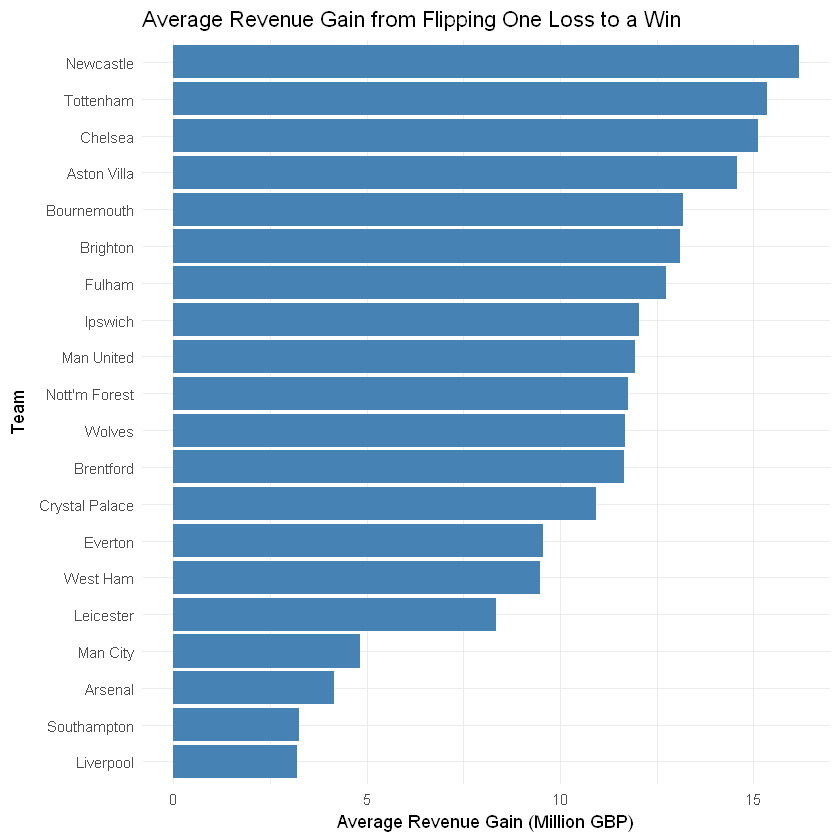

In [29]:
ggplot(avg_revenue_gain_df, aes(x = reorder(team, avg_gain), y = avg_gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Average Revenue Gain from Flipping One Loss to a Win",
    x = "Team",
    y = "Average Revenue Gain (Million GBP)"
  ) +
  theme_minimal()

## Question 4

Baseline Season: Simulate 1,000 full seasons using each team's original attack (alpha) and defense (delta) values.

   + Assign revenue based on final rank in each season.
   + Compute each team’s average baseline revenue.

Attack Boost (One Team at a Time):

   + For each team, increase its alpha value by 10%.
   + Simulate another 10 seasons with this change (others unchanged).
   + Re-rank teams and assign revenue for each simulation.

Compare the new average revenue to the baseline.

Marginal Effect:

   + Calculate the average revenue gain for each team resulting from the attack improvement.
   
1,000 baseline simulations and 10 simulations for each of 20 teams with the alpha boost

Total: 1,200 simulated **full seasons**

**Findings**

revenue is distributed based on relative league position, not on absolute performance metrics like goals scored. So, even if a team scores more goals, it won’t necessarily lead to more points or a higher ranking—especially if the wins don’t come in the right matches or if key games are still lost (since this is still a probabalistic model).

One aspect of performance does not guarantee financial improvement

In [30]:
set.seed(8)

# Prepare to store marginal revenue gains
attack_boost_results <- data.frame(team = character(), avg_revenue_gain = numeric())

# Compute baseline revenue
baseline_revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(baseline_revenue_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  points <- as.numeric(season_sims[i, ])
  names(points) <- colnames(season_sims)
  ranking <- names(sort(points, decreasing = TRUE))
  baseline_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
}
baseline_revenue_avg <- colMeans(baseline_revenue_matrix)

# Run simulations for each team with 10% alpha increase
for (team in team_names) {
  # Modify alpha (increase attack for one team)
  boosted_alpha <- alphaList
  boosted_alpha[team] <- boosted_alpha[team] * 1.10

  # Run simulations
  num_sims <- 10
  boosted_points <- matrix(NA, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_points) <- team_names

    # 🟦 Set up season-level progress bar
  pb <- txtProgressBar(min = 0, max = num_sims, style = 3)

  for (i in 1:num_sims) {
    sim <- simulate_season_l(boosted_alpha, deltaList, team_names)
    boosted_points[i, names(sim$points)] <- sim$points
      
       # 🟩 Update progress
    setTxtProgressBar(pb, i)
  }
    
close(pb)  # ✅ 

  # Convert points to revenue
  boosted_revenue_matrix <- matrix(0, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_revenue_matrix) <- team_names

  for (i in 1:num_sims) {
    pts <- as.numeric(boosted_points[i, ])
    names(pts) <- colnames(boosted_points)
    ranking <- names(sort(pts, decreasing = TRUE))
    boosted_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
  }

  # Average gain for that team
  revenue_gain <- colMeans(boosted_revenue_matrix) - baseline_revenue_avg
  attack_boost_results <- rbind(
    attack_boost_results,
    data.frame(team = team, avg_revenue_gain = revenue_gain[team])
  )
}

# Sort and display results
attack_boost_results <- attack_boost_results %>% arrange(desc(avg_revenue_gain))
print(attack_boost_results)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

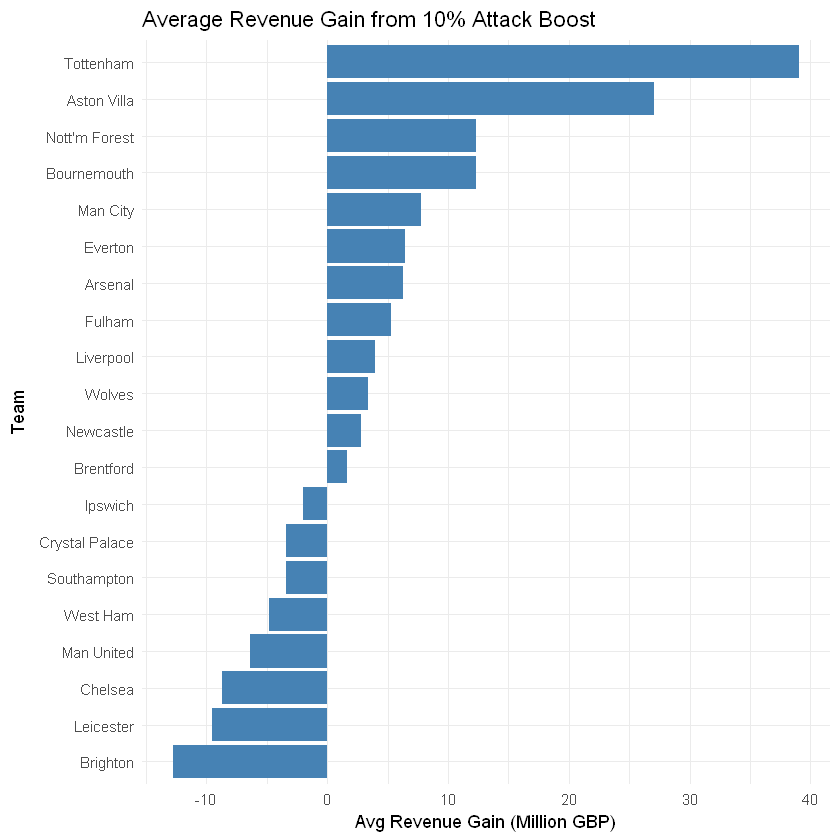

In [31]:
library(ggplot2)

# Plot the results
ggplot(attack_boost_results, aes(x = reorder(team, avg_revenue_gain), y = avg_revenue_gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Average Revenue Gain from 10% Attack Boost",
    x = "Team",
    y = "Avg Revenue Gain (Million GBP)"
  ) +
  theme_minimal()


In [32]:
set.seed(8)

# Prepare to store marginal revenue gains
defense_boost_results <- data.frame(team = character(), avg_revenue_gain = numeric())

# Compute baseline revenue
baseline_revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(baseline_revenue_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  points <- as.numeric(season_sims[i, ])
  names(points) <- colnames(season_sims)
  ranking <- names(sort(points, decreasing = TRUE))
  baseline_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
}
baseline_revenue_avg <- colMeans(baseline_revenue_matrix)

# Run simulations for each team with 10% delta decrease (better defense)
for (team in team_names) {
  # Modify delta (decrease expected goals conceded for one team)
  boosted_delta <- deltaList
  boosted_delta[team] <- boosted_delta[team] * 0.90

  # Run simulations
  num_sims <- 10
  boosted_points <- matrix(NA, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_points) <- team_names

  # 🟦 Set up season-level progress bar
  pb <- txtProgressBar(min = 0, max = num_sims, style = 3)

  for (i in 1:num_sims) {
    sim <- simulate_season_l(alphaList, boosted_delta, team_names)
    boosted_points[i, names(sim$points)] <- sim$points

    # 🟩 Update progress
    setTxtProgressBar(pb, i)
  }

  close(pb)  # ✅ Close progress bar

  # Convert points to revenue
  boosted_revenue_matrix <- matrix(0, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_revenue_matrix) <- team_names

  for (i in 1:num_sims) {
    pts <- as.numeric(boosted_points[i, ])
    names(pts) <- colnames(boosted_points)
    ranking <- names(sort(pts, decreasing = TRUE))
    boosted_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
  }

  # Average gain for that team
  revenue_gain <- colMeans(boosted_revenue_matrix) - baseline_revenue_avg
  defense_boost_results <- rbind(
    defense_boost_results,
    data.frame(team = team, avg_revenue_gain = revenue_gain[team])
  )
}

# Sort and display results
defense_boost_results <- defense_boost_results %>% arrange(desc(avg_revenue_gain))
print(defense_boost_results)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

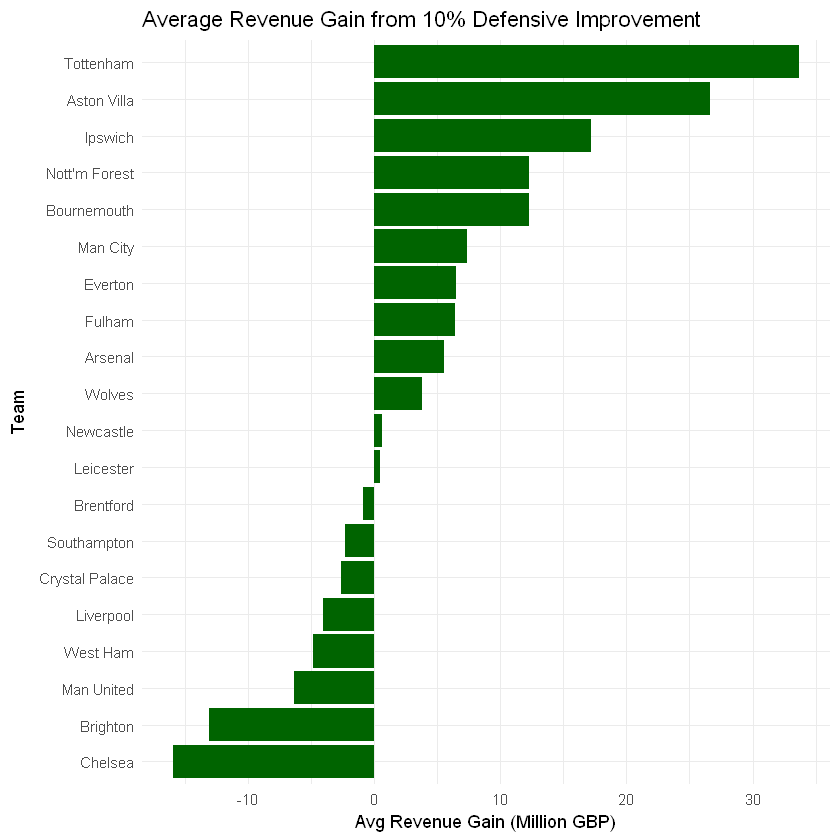

In [33]:
# Plot the results
ggplot(defense_boost_results, aes(x = reorder(team, avg_revenue_gain), y = avg_revenue_gain)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Average Revenue Gain from 10% Defensive Improvement",
    x = "Team",
    y = "Avg Revenue Gain (Million GBP)"
  ) +
  theme_minimal()